In [35]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as mpl

import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


#ライブラリnumbaのインストールが必要
#pip install numba

# 8.6　人工データによる実験

## スニペット8.7 人工データセットの作成


In [36]:
def getTestData(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):
    #ランダムなデータセットを作成
    from sklearn.datasets import make_classification
    trnsX, cont = make_classification(
        n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, random_state=0, shuffle=False
    )
    #df0 = pd.DatetimeIndex(periods=n_samples, freq=pd.tseries.offsets.BDay(), end = pd.datetime.today())
    df0 = pd.bdate_range(end=pd.Timestamp.today(), periods=n_samples)

    trnsX, cont= pd.DataFrame(trnsX,index=df0), pd.Series(cont,index=df0).to_frame('bin')

    #xrangeは古いのでrangeを使用
    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]

    trnsX.columns = df0

    cont['w'] = 1./cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index=cont.index)

    return trnsX, cont

    バージョンアップのため変更あり

xrange→range


df0 = pd.DatetimeIndex(periods=n_samples, freq=pd.tseries.offsets.BDay(), end = pd.datetime.today())

    
df0 = pd.bdate_range(end=pd.Timestamp.today(), periods=n_samples)

解説

bdate_rangeはその期間の営業日を取得

https://pandas.pydata.org/docs/dev/reference/api/pandas.bdate_range.html

make_classification：分類問題を作成

binが答え

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

https://scikit-learn.org/stable/datasets/sample_generators.html#sample-generators


In [37]:
trnsX, cont = getTestData(n_samples=500)

In [38]:
trnsX

,I_0,I_1,I_2,I_3,I_4,I_5,I_6,I_7,I_8,I_9,...,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19
2021-08-10,-1.437453,-1.461372,4.431212,-2.489014,2.406970,0.832023,-0.359840,1.589980,-0.413212,-0.656383,...,-0.765226,-0.077640,0.575670,0.551034,0.600293,1.109558,-0.360985,1.120129,0.334544,0.157896
2021-08-11,-0.238303,-3.075863,2.931658,0.207164,2.942798,0.718780,-1.243549,1.058914,-5.250354,-0.046295,...,-0.072546,0.623351,1.192175,1.471532,0.791971,-0.844757,0.124144,-0.713904,-0.460423,-0.475682
2021-08-12,-0.378601,-0.795449,5.582848,-0.427981,3.361399,-1.109409,-1.982763,-2.875320,3.256004,-0.353344,...,0.692742,-0.779134,-0.297421,0.220336,0.434984,0.524904,-0.473790,-1.359320,-2.259976,-0.893481
2021-08-13,1.723395,0.180378,1.041976,0.952406,-0.195189,-0.750095,2.157243,0.571013,-1.712737,-2.500987,...,-0.777234,-1.328378,-1.401197,0.462693,2.381686,-1.208986,-0.418867,-0.785321,-2.164551,1.144581
2021-08-16,0.502976,-1.807104,-0.142785,0.714731,1.019577,0.170125,1.870629,5.720943,-1.490285,-1.334797,...,-0.387744,-0.606736,1.536559,0.171157,0.013563,0.128522,0.123785,-1.612687,-0.169906,1.718791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-04,0.193694,-3.499856,0.312950,2.456082,-2.102443,-1.036584,0.060421,-3.466299,-3.842514,-0.418507,...,0.553054,-0.217864,0.657201,-0.766092,-0.150479,-0.695512,-0.803991,0.193570,-0.610769,1.477575
2023-07-05,-0.656228,2.646874,-0.223303,-0.917770,-1.425441,-4.290823,0.067152,-0.025520,-1.296992,0.628903,...,-1.012504,2.362787,-1.048423,0.020295,-1.629144,1.546046,-0.262670,-1.371694,1.744837,-1.900396
2023-07-06,0.650759,0.025799,4.096156,0.776335,-1.532975,-2.723444,1.465252,-4.159810,-3.288873,-2.353611,...,-2.176290,0.540146,-0.523219,0.686370,1.725276,0.945338,-1.227187,-0.528763,-0.557393,1.140021
2023-07-07,-2.318740,1.269892,-1.929802,-0.535293,-1.999401,-1.578499,-5.001459,3.223076,1.091732,0.365437,...,-0.207416,1.181063,1.387658,0.434387,1.018736,-0.346987,-0.069790,0.684972,-0.793864,1.081068


In [39]:
cont

,bin,w,t1
2021-08-10,0,0.002,2021-08-10
2021-08-11,0,0.002,2021-08-11
2021-08-12,0,0.002,2021-08-12
2021-08-13,0,0.002,2021-08-13
2021-08-16,0,0.002,2021-08-16
...,...,...,...
2023-07-04,1,0.002,2023-07-04
2023-07-05,1,0.002,2023-07-05
2023-07-06,1,0.002,2023-07-06
2023-07-07,1,0.002,2023-07-07


binが分類の答え

wはよくわからないが、たぶんウェイト

t1は日付（インデックスと同じ）

dataに保存しておく

In [40]:
#trnsX.to_csv("./data/chap8_trnsX.csv")
#cont.to_csv("./data/chap8_cont.csv")

In [54]:
#スニペット8.10 特徴量重要度プロット関数
    #スニペット8.9で使用

def plotFeatImportance(pathOut, imp, oob, oos, method, tag=0, simNum=0, **kargs):
    #impの平均値バーを標準偏差によってプロットする
    mpl.figure(figsize=(10, imp.shape[0]/5.))
    imp = imp.sort_values('mean', ascending=True)
    ax=imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor':'r'})

    if method == 'MDI':
        mpl.xlim([0,imp.sum(axis=1).max()])
        mpl.axvline(1./imp.shape[0], linewidth=1, color='r', linestyle='dotted')
    
    ax.get_yaxis().set_visible(False)

    for i,j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2, i.get_y() + i.get_height()/2, j, ha='center', va='center', color='black')
    
    mpl.title('method=' + str(method) + ' | tag=' + str(tag) + ' | simNum=' +str(simNum) + ' | oob=' + str(round(oob,4)) + ' | oos=' + str(round(oos, 4)))
    mpl.savefig(pathOut + str(method) + '_featImportance_' + str(simNum) + '.png', dpi=100)
    mpl.clf()
    mpl.close()

    return

# 8.3 代替効果による特徴量重要度



## スニペット8.2 MDI特徴量重要性

In [42]:
def featImpMDI(fit, featNames):
    #ISで平均不純度減少量に基づく特徴量重要度
    df0 = {i:tree.feature_importances_ for i,tree in enumerate (fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0,np.nan) # max_features=1のため
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std()*df0.shape[0]**-.5}, axis=1)
    imp /= imp['mean'].sum()

    return imp

人工データでやってみる

スニペット8.8を編集し、サンプルデータにフィットする関数を作成

分類器として決定木を使用


In [43]:
def fit_sample_data(trnsX, cont, n_estimators=1000, cv=10, max_samples=1., numThreads=24, pctEmbargo=0, scoring='accuracy', method='SFI', minWLeaf=0., **kargs):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import BaggingClassifier

    #謎のライブラリをインポートしているのでコメントアウトしておく
    #from mpEngine import mpPandas0bj

    n_jobs = (-1 if numThreads>1 else 1) #dirac1のht_helperの場合は1スレッドのみをはしらせる

    # 1) classifierとcvを用意する。
    # マスキングを避けるためにmax_features=1とする

#ジニ不純度で分類するように変更
    clf = DecisionTreeClassifier(criterion='gini', max_features=1, class_weight='balanced', min_weight_fraction_leaf=minWLeaf)

    #base_estimatorはestimatorに変わった
    #clf = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators, max_features=1., max_samples=max_samples, oob_score=True, n_jobs=n_jobs)
    clf = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators, max_features=1., max_samples=max_samples, oob_score=True, n_jobs=n_jobs)

    fit = clf.fit(X = trnsX, y=cont['bin'], sample_weight=cont['w'].values)
    oob = fit.oob_score_

    return fit, oob, clf


In [44]:
# スニペット7.3, 7.4を利用
from sklearn.model_selection import KFold
class PurgedKFold(KFold):
  '''
  区間にまたがるラベルに対して機能するようにkFoldクラスを拡張する
  訓練データのうちテストラベル区間と重複する観測値がパージされる
  テストデータセットは連続的(shuffle=False)で、間に訓練データがないとする
  '''

  def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
    if not isinstance(t1, pd.Series):
      raise ValueError('Label Through Dates must be a pd.Series')
    super(PurgedKFold, self).__init__(n_splits,shuffle=False,random_state=None)
    self.t1=t1
    self.pctEmbargo=pctEmbargo

  def split(self,X,y=None,groups=None):
    if (X.index==self.t1.index).sum()!=len(self.t1):
      raise ValueError('X and ThruDateValues must have the same index')
    indices=np.arange(X.shape[0])
    mbrg=int(X.shape[0]*self.pctEmbargo)
    test_starts=[(i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),self.n_splits)]
    for i,j in test_starts:
      t0=self.t1.index[i] #テストデータセットの始まり
      test_indices=indices[i:j]
      maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
      train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
      train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
    yield train_indices, test_indices


def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None,pctEmbargo=None):
  if scoring not in ['neg_log_loss', 'accuracy']:
    raise Exception('wrong scoring method.')
  from sklearn.metrics import log_loss, accuracy_score
  # from clfSequential import PurgedKFold

  if cvGen is None:
    #パージ
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo)
  score=[]
  for train,test in cvGen.split(X = X):
    fit = clf.fit(X = X.iloc[train, : ], y = y.iloc[train], sample_weight = sample_weight.iloc[train].values)
    if scoring == 'neg_log_loss':
      prob = fit.predict_proba(X.iloc[test, : ])
      score_ = -1 * log_loss(y.iloc[test], prob, sample_weight = sample_weight.iloc[test].values, labels = clf.classes_)
    else:
      pred = fit.predict(X.iloc[test, : ])
      score_ = accuracy_score(y.iloc[test], pred, sample_weight = sample_weight.iloc[test].values)
    score.append(score_)
  return np.array(score)

In [45]:
fit, oob, clf = fit_sample_data(trnsX, cont)
oos = cvScore(clf, X=trnsX, y=cont['bin'], cv=10, sample_weight=cont['w'], t1=cont['t1'],pctEmbargo=0).mean()

c:\anaconda3\envs\stdpyenv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\anaconda3\envs\stdpyenv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [55]:
MDI_imp = featImpMDI(fit, featNames=trnsX.columns)

In [47]:
MDI_imp

,mean,std
I_0,0.031759,0.000873
I_1,0.025429,0.000612
I_2,0.024726,0.000597
I_3,0.024362,0.000584
I_4,0.030124,0.000823
I_5,0.028729,0.000757
I_6,0.028788,0.000767
I_7,0.024403,0.000640
I_8,0.040867,0.001307
I_9,0.029550,0.000753


In [56]:
path_out = './chap8_out/'
plotFeatImportance(pathOut=path_out, imp=MDI_imp, oob=oob, oos=oos, method='MDI')

## スニペット8.3 MDAによる特徴量重要度測定

In [148]:
def featImpMDA(clf, X,y,cv,sample_weight, t1, pctEmbargo, scoring='neg_log_loss'):
    #アウトオブサンプルでのスコア低下に基づく特徴量重要度

    #スコアリングメソッドが間違っていたら弾く
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('wrong scoring method.')

    from sklearn.metrics import log_loss, accuracy_score

    #パージ付きcv（7章）
    cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)

    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0, w0 = X.iloc[train,:], y.iloc[train], sample_weight.iloc[train]
        X1,y1,w1 = X.iloc[test,:], y.iloc[test], sample_weight.iloc[test]
        fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)

        #並べ替え前のスコアをはかる
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)

        else:
            #scoring==accurateの場合
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred, sample_weight = w1.values)

        # 並べ替え後のスコアをはかる
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) #1列並べ替え

            if scoring == 'neg_log_loss':
                prob = fit.predict_proba(X1_)
                scr1.loc[i,j] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)

            else:
                pred = fit.predict(X1_)
                scr1.loc[i,j] = accuracy_score(y1, pred, sample_weight=w1.values)

    imp = (-scr1).add(scr0, axis=0)

    if scoring == 'neg_log_loss':
        imp = imp/-scr1

    else:
        imp = imp/(1.-scr1)

    #テスト用
    imp_test = imp

#標準偏差の計算は工夫する
    imp = pd.concat({'mean':imp.mean(), 'std': imp.std(axis=1)*imp.shape[0]**-.5}, axis=1)
    #imp = pd.concat({'mean':imp.mean(), 'std': imp.std(axis=1).values*imp.shape[0]**-.5}, axis=1)
    
    return imp, scr0.mean(), imp_test

人工データでやってみる

In [149]:
MDA_imp, MDA_scr0_mean, imp_test = featImpMDA(clf, X=trnsX, y=cont['bin'],cv=10,sample_weight=cont['w'], t1=cont['t1'],pctEmbargo=0)

C:\Users\sinya\AppData\Local\Temp\ipykernel_29512\913702038.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
c:\anaconda3\envs\stdpyenv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [107]:
MDA_imp

,mean,std
I_0,0.003146,NaN
I_1,0.007428,NaN
I_2,0.011455,NaN
I_3,0.008260,NaN
I_4,-0.002592,NaN
I_5,0.002127,NaN
I_6,0.005873,NaN
I_7,0.012669,NaN
I_8,0.005739,NaN
I_9,0.015454,NaN


In [108]:
imp_test.std(axis=1).values

array([0.00509432])

In [131]:
np.zeros(imp_test.shape)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [146]:
imp_test2 = pd.concat({'mean':imp_test.mean(), 'std': pd.DataFrame(np.ones(imp_test.shape[0]))}, axis=1)

In [147]:
imp_test2

,mean,std
,0,0
I_0,0.003146,NaN
I_1,0.007428,NaN
I_2,0.011455,NaN
I_3,0.008260,NaN
I_4,-0.002592,NaN
I_5,0.002127,NaN
I_6,0.005873,NaN
I_7,0.012669,NaN
I_8,0.005739,NaN


In [80]:
MDA_imp

,mean,std
I_0,0.012216,NaN
I_1,0.006071,NaN
I_2,0.006438,NaN
I_3,0.003386,NaN
I_4,-0.001495,NaN
I_5,0.012161,NaN
I_6,0.004228,NaN
I_7,0.003859,NaN
I_8,0.001596,NaN
I_9,0.010901,NaN


In [85]:
MDA_imp['mean']

I_0     0.012216
I_1     0.006071
I_2     0.006438
I_3     0.003386
I_4    -0.001495
I_5     0.012161
I_6     0.004228
I_7     0.003859
I_8     0.001596
I_9     0.010901
R_0     0.009739
R_1    -0.000769
R_2     0.011827
R_3    -0.000127
R_4     0.003679
R_5     0.012184
R_6    -0.001434
R_7     0.016640
R_8     0.011099
R_9    -0.002815
N_0     0.002528
N_1     0.004494
N_2     0.005104
N_3    -0.000973
N_4     0.005065
N_5     0.003730
N_6     0.004030
N_7    -0.002216
N_8     0.004502
N_9     0.003238
N_10    0.004860
N_11    0.009345
N_12    0.005062
N_13    0.001374
N_14   -0.003505
N_15    0.002616
N_16    0.003495
N_17    0.003086
N_18    0.006123
N_19    0.003843
Name: mean, dtype: float64

In [81]:
MDA_scr0_mean

-0.6498546001614994

StopIteration: 

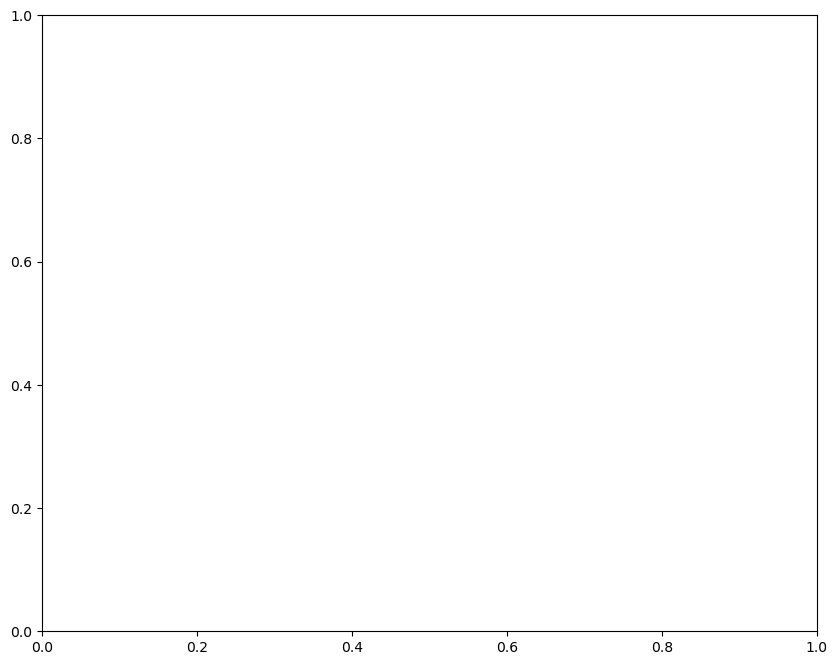

In [88]:
plotFeatImportance(pathOut=path_out, imp=MDA_imp, oob=oob, oos=MDA_scr0_mean, method='MDA')

# 8.4 代替効果を除いた特徴量重要度

## 8.4.1 単一特徴量重要度

In [ ]:
#スニペット8.4 SFIの実装

def auxFeatImpSFI(featNames, clf, trnsX, cont, scoring, cvGen):
    imp = pd.DataFrame(columns=['means','std'])

    for featName in featNames:
        df0 = cvScore(clf, X=trnsX[[featName]],y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)

        imp.iloc[featName, 'mean'] = df0.mean()
        imp.loc[featName, 'std'] = df0.std()*df0.shape[0]**-.5

    return imp

In [ ]:
#人工データでやってみる



## 8.4.2 特徴量の直交化

In [ ]:
#スニペット8.5 直交特徴量の計算

def get_eVec(dot, varThres):
    #dot prod行列からeVec(固有ベクトル)を計算し、次元を圧縮する
    eVal, eVec = np.linalg.eigh(dot)
    idx = eval.argsort()[::-1] # eVal(固有値)を降順にソートするための引数
    eVal, eVec = eVal[idx], eVec[:,idx]

    #2) 正の固有値のみ
    eVal = pd.Series(eVal, index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
    eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index)
    eVec = eVec.iloc[:, eVal.index]

    #3) 主成分によって次元削減する
    cumVar = eVal.cumsum()/eVal.sum()
    dim = cumVar.values.searchsorted(varThres)
    eVal, eVec = eVal.iloc[:dim+1], eVec.iloc[:,:dim+1]

    return eVal, eVec

In [ ]:
def orthoFeats(dfX, varThres=.95):
    #特徴量のデータフレームdfXに対し、直交化した特徴量dfPを計算する
    dfZ = dfX.sub(dfX.mean(),axis=1).div(dfX.std(), axis=1) #標準化
    dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
    eVal, eVec = get_eVec(dot, varThres)
    dfP = np.dot(dfZ, eVec)
    return dfP

In [ ]:
# スニペット8.6 特徴量重要度と逆PCA順位の間のケンドール加重タウの計算

from scipy.stats import weightedtau

featImp = np.array([.55, .33, .07, 0.5]) #特徴量重要度
pcRank = np.array([1,2,4,3]) #PCAランク
weightedtau(featImp, pcRank**-1.)[0] 


# 8.6節

In [ ]:
#7章のスニペット7.4

def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None,pctEmbargo=None):
  if scoring not in ['neg_log_loss', 'accuracy']:
    raise Exception('wrong scoring method.')
  from sklearn.metrics import log_loss, accuracy_score
  # from clfSequential import PurgedKFold

  if cvGen is None:
    #パージ
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo)
  score=[]
  for train,test in cvGen.split(X = X):
        fit = clf.fit(X = X.iloc[train, : ], y = y.iloc[train], sample_weight = sample_weight.iloc[train].values)
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X.iloc[test, : ])
            score_ = -1 * log_loss(y.iloc[test], prob, sample_weight = sample_weight.iloc[test].values, labels = clf.classes_)
        else:
            pred = fit.predict(X.iloc[test, : ])
            score_ = accuracy_score(y.iloc[test], pred, sample_weight = sample_weight.iloc[test].values)
        score.append(score_)
  return np.array(score)

## スニペット8.8

デフォルトの分類器としてバギング決定木を使用

３つの特徴量重要度手法が機能しているかどうか評価するため、同じデータセットに対して各分析を実行できる関数を定義する

In [ ]:
def featImportance(trnsX, cont, n_estimators=1000, cv=10, max_samples=1., numThreads=24, pctEmbargo=0, scoring='accuracy', method='SFI', minWLeaf=0., **kargs):

    #20章のmpEngineを利用する
    #mpEngine.pyがワーキングディレクトリにあればインポートできる
    from mpEngine import mpPandasObj

    n_jobs = (-1 if numThreads>1 else 1) #dirac1のht_helperの場合は1スレッドのみをはしらせる

    # 1) classifierとcvを用意する。
    # マスキングを避けるためにmax_features=1とする

    clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=minWLeaf)

    #base_estimatorはestimatorに変わったので、バージョンに合わせる
    clf = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators, max_features=1., max_samples=max_samples, oob_score=True, n_jobs=n_jobs)
    #clf = BaggingClassifier(estimator=clf, n_estimators=n_estimators, max_features=1., max_samples=max_samples, oob_score=True, n_jobs=n_jobs)

    fit = clf.fit(X = trnsX, y=cont['bin'], sample_weight=cont['w'].values)
    oob = fit.oob_score_

    if method == 'MDI':
        imp = featImpMDI(fit, featNames=trnsX.columns)

        #7章のスニペット7.4を使用している
        oos = cvScore(clf, X=trnsX, y=cont['bin'], cv=cv, sample_weight=cont['w'], t1=cont['t1'],pctEmbargo=pctEmbargo, scoring=scoring).mean()

    elif method == 'MDA':
        imp, oos = featImpMDA(clf, X=trnsX, y=cont['bin'], cv=cv, sample_weight=cont['w'], t1=cont['t1'], pctEmbargo=pctEmbargo, scoring=scoring)

    elif method == 'SFI':
        cvGen = PurgedKFold(n_splits=cv, t1=cont['t1'], pctEmbargo=pctEmbargo)
        oos = cvScore(clf, X=trnsX, y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen).mean()
        clf.n_jobs=1 # clfではなくauxFeatImpSFIを並列化する
        imp=mpPandasObj(auxFeatImpSFI, ('featNames', trnsX.columns), numThreads, clf=clf, trnsX=trnsX, cont=cont, scoring=scoring,cvGen=cvGen)

    return imp, oob, oos

In [ ]:
#featImportance(trnsX, cont, n_estimators=10)

In [ ]:
#スニペット8.10 特徴量重要度プロット関数
    #スニペット8.9で使用

def plotFeatImportance(pathOut, imp, oob, oos, method, tag=0, simNum=0, **kargs):
    #impの平均値バーを標準偏差によってプロットする
    mpl.figure(figsize=(10, imp.shape[0]/5.))
    imp = imp.sort_values('mean', ascending=True)
    ax=imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor':'r'})

    if method == 'MDI':
        mpl.xlim([0,imp.sum(axis=1).max()])
        mpl.axvline(1./imp.shape[0], linewidth=1, color='r', linestyle='dotted')
    
    ax.get_yaxis().set_visible(False)

    for i,j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2, i.get_y() + i.get_height()/2, j, ha='center', va='center', color='black')
    
    #mpl.title('tag=' + tag + ' | simNum=' + str(simNum) + ' | oob=' + str(round(oob,4)) + ' | oos=' + str(round(oos, 4)))
    mpl.savefig(pathOut + 'featImportance_' + str(simNum) + '.png', dpi=100)
    mpl.clf()
    mpl.close()

    return

In [ ]:
#スニペット8.9 全要素の呼び出し
def testFunc(n_features=40, n_informative=10, n_redundant=10, n_estimators=1000, n_samples=10000, cv=10):
    #人工データにおける特徴量重要度関数のパフォーマンスを測定する
    #ノイズ比率、すなわちノイズ特徴量=n_features-n_informative-n_redundantである

    trnsX, cont = getTestData(n_features, n_informative, n_redundant, n_samples)
    dict0 = {'minWLeaf':[0.], 'scoring':['accuracy'], 'method':['MDI', 'MDA', 'SFI'], 'max_samples':[1.]}


    #jobs, out = (dict(izip(dict0, i)) for i in product(*dict0.values())),[]
    jobs, out = (dict(zip(dict0, i)) for i in itertools.product(*dict0.values())),[]
    kargs = {'pathOut':'./testFunc/', 'n_estimators':n_estimators, 'tag':'testFunc', 'cv':cv}

    for job in jobs:
        job['simNum'] = job['method'] + '_' + job['scoring'] + '_' + '%.2f'%job['minWLeaf'] + '_' + str(job['max_samples'])
        print(job['simNum'])

        kargs.update(job)
        imp, oob, oos = featImportance(trnsX=trnsX, cont=cont,**kargs)
        plotFeatImportance(imp=imp, oob=oob, oos=oos, **kargs)

        df0 = imp[['mean']]/imp['mean'].abs().sum()
        df0['type'] = [i[0] for i in df0.index]
        df0 = df0.groupby('type')['mean'].sum().to_dict()
        df0.update({'oob':oob, 'oos': oos})
        df0.update(job)
        out.append(df0)

    out = pd.DataFrame(out).sort_values(['method','scoring','minWLeaf', 'max_samples'])
    out=out['method', 'scoring', 'minWLeaf', 'max_samples', 'I', 'R', 'N', 'oob', 'oos']
    out.to_csv(kargs['pathOut'] + 'stats.csv')
    
    return
        


実行に時間がかかるため、n_estimators=100, n_samples=1000にしてデータや試行回数を減らしている。
それでもかなりの時間がかかった。

In [ ]:
testFunc(n_estimators=100, n_samples=1000)